# <u>Aquaverse Short Course Part II:</u> Understanding Mixture Density Network (MDN) Output and Uncertainty Estimation

This notebook covers the MDN outputs and how final estimates are derived from those outputs. Additionally, the notebook illustrates how the MDN output provides a measure of confidence in the model's predictions on specific samples. The notebook will walk a user through: 

<ol> 
    <li> Selecting samples from the <a href="https://doi.pangaea.de/10.1594/PANGAEA.948492"> GLObal Reflectance community dataset for Imaging and optical sensing of Aquatic environments (GLORIA)</a> dataset to illustrate the the output properties of the MDN.</li>
    <li> A brief description of the prediction-uncertainty in machine learning models and the theory of uncertainty estimation for MDNs.</li>
    <li> Illustrating the uncertainty estimation and its possible applications.</li>
</ol>

Freshwater Sensing Group </br>
Science Systems and Applications, Inc./ NASA Goddard Spaceflight Center.</br>
September 2024

<p><b style="color:blue"> Contact Info:</b> </p>
<p><u>BPs & IOP Products:</u><b> Ryan E. O'Shea:</b>  ryan.oshea@ssaihq.com (ryan.e.o'shea@nasa.gov)</p>
<p><u>Uncertainties:</u><b> Arun Saranathan:</b> arun.saranathan@ssaihq.com (fnu.arunmuralidharansaranathan@nasa.gov)</p>
<p><u>Atmospheric Correction:</u><b> Akash Ashapure:</b>  akash.ashapure@ssaihq.com (akash.ashapure@nasa.gov)</p>

In [1]:
'Import the base python packages needed for this notebook'
import numpy                                                          as np
import scipy
import os
from   pathlib                    import Path
from   urllib.request             import urlretrieve
import zipfile
import matplotlib                                                     as mpl
import matplotlib.pyplot                                              as plt
import matplotlib.patches                                             as patches
from   matplotlib                 import ticker
from   matplotlib.colors          import LogNorm

'Import some MDN specific functions and packages'
from   MDN                        import get_sensor_bands, get_tile_data
from   MDN                        import current_support 
from   MDN                        import get_gloria_trainTestData, get_args
from   MDN                        import get_mdn_preds, get_mdn_uncert_ensemble, create_scatterplots_trueVsPred, performance
from   MDN                        import OC 

In [2]:
'Set display parameters for MATPLOTLIB'
plt.rcParams.update({"text.usetex": False,})
if plt.rcParams['text.usetex']:
    plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
    
plt.rcParams['mathtext.default']='regular'
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
mrkSize = 15
ASPECT="auto"
cmap = "jet"

mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

<b> <font size="+1" color="red">Section 1: Visualizing the GLORIA Samples Chosen for Analysis</font></b>

In [3]:
'Let us first download the GLORIA dataset if not available'
if not os.path.exists("data"):
    print(f"Target folder not found. Creating folder data in {os.getcwd()}")
    os.makedirs("data")

if not os.path.exists("data/GLORIA-2022.zip"):
    !curl -o data/GLORIA-2022.zip https://download.pangaea.de/dataset/948492/files/GLORIA-2022.zip

In [4]:
'Set up the details and extract the GLORIA data to a folder called GLORIA-2022'
zip_file_path = 'data/GLORIA-2022.zip'  # Replace with your zip file path
extract_to_dir = 'data/'  # Replace with your extraction directory

'Unzip the downloaded zip file'    
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)
    print(f'Files extracted to {extract_to_dir}')

Files extracted to data/


In [5]:
'Set the GLORIA folder and extract the data'
gloria_folder = Path().cwd() / 'data/GLORIA_2022/'

assert gloria_folder.is_dir(), f"No folder found art {gloria_folder}"
'Get the GLORIA data at the resolution of the OLCI sensor'
x_data, y_data, gid_data = get_gloria_trainTestData(sensor='OLCI', out_var=["chl"],
                                                    save_flag=False, load_exists=False,rand_seed=42,
                                                    rem_flagged=True, gloria_folder=gloria_folder,
                                                    flag_name='GLORIA_qc_flags.csv', rrs_name='GLORIA_Rrs.csv',
                                                    bg_name='GLORIA_meta_and_lab.csv', gloria_only=True,
                                                    train_mode=False)
'Get the wavelengths available for this sensor'
wvl_bands = get_sensor_bands("OLCI")

  1%|▉                                                                                                                                                     | 49/7572 [00:00<00:15, 484.32it/s]

Bands with responses outside of range [350, 899]: 
 [900.0, 940.0, 1020.0]

Creating data for bands
 [400.0, 412.5, 442.5, 490.0, 510.0, 560.0, 620.0, 665.0, 673.75, 681.25, 708.75, 753.75, 761.25, 764.375, 767.5, 778.75, 865.0, 885.0]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7572/7572 [00:15<00:00, 501.96it/s]


For visualization we will consider two spectra showing different water conditions. Sample-1 (<a style="font-family:'Courier New'">GID-1367</a>) shows a sample with intermediate levels of chlorophyll, while the Sample-2 (<a style="font-family:'Courier New'">GID-2974</a>) shows a sample from a highly eutrophic location. We will now try to extract the outputs for these samples and visualize what they look like.

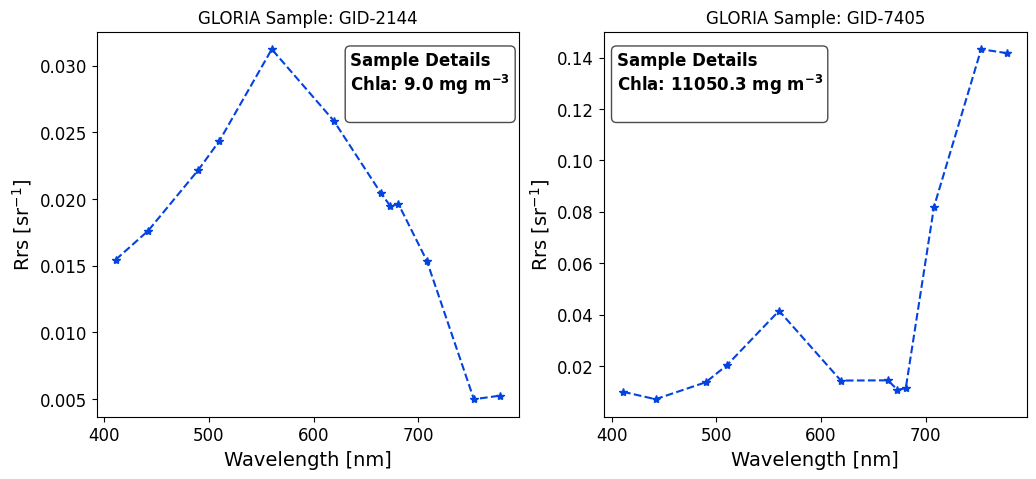

In [26]:
'Visualize a sample from the Gloria data'
idx_1 = np.where(gid_data == "GID_2144")[0]    #np.random.choice(x_data.shape[0])
idx_2 = np.where(gid_data == "GID_7405")[0]
fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].plot(wvl_bands, np.squeeze(x_data[idx_1, :]), linestyle="--", marker="*", color="xkcd:blue")
ax[0].set_title("GLORIA Sample: " + gid_data[idx_1][0].replace('_', '-'));
ax[0].set_xlabel('Wavelength [nm]');
ax[0].set_ylabel(r'Rrs [$sr^{-1}$]');

label= []
for item in y_data[idx_1, :][0]:
    if np.isnan(item):
        label += ['N/A']
    else:
        label+= [f'{item:.1f}']

if plt.rcParams['text.usetex']:
    textstr1 = (r"\underline{\textbf{Sample Details}}" + '\n' + r"\textbf{Chla}:" + f' {label[0]} ' + r"$mg~m^{-3}$" + '\n')
else:
    textstr1 = (r"Sample Details" + '\n' + r"Chla:" + f' {label[0]} ' + r"$mg~m^{-3}$" + '\n')

    #+ r"\textbf{TSS:}" + f'           {label[1]} ' + r"$mg~m^{-3}$" + '\n'  + r"\textbf{acdom:}" + f'    {label[2]} ' + r"$m^{-1}$ " + '\n');
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax[0].text(0.6, 0.95, textstr1, transform=ax[0].transAxes, fontsize=SMALL_SIZE*1, weight="bold", verticalalignment='top', bbox=props);

ax[1].plot(wvl_bands, np.squeeze(x_data[idx_2, :]), linestyle="--", marker="*", color="xkcd:blue")
ax[1].set_title("GLORIA Sample: " + gid_data[idx_2][0].replace('_', '-'));
ax[1].set_xlabel('Wavelength [nm]');
ax[1].set_ylabel(r'Rrs [$sr^{-1}$]');

label= []
for item in y_data[idx_2, :][0]:
    if np.isnan(item):
        label += ['N/A']
    else:
        label+= [f'{item:.1f}']
        
if plt.rcParams['text.usetex']:
    textstr1 = (r"\underline{\textbf{Sample Details}}" + '\n' + r"\textbf{Chla}:" + f' {label[0]} ' + r"$mg~m^{-3}$" + '\n')
else:
    textstr1 = (r"Sample Details" + '\n' + r"Chla:" + f' {label[0]} ' + r"$mg~m^{-3}$" + '\n')

    #+ r"\textbf{TSS:}" + f'           {label[1]} ' + r"$mg~m^{-3}$" + '\n'  + r"\textbf{acdom:}" + f'    {label[2]} ' + r"$m^{-1}$ " + '\n');
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax[1].text(0.03, 0.95, textstr1, transform=ax[1].transAxes, fontsize=SMALL_SIZE*1, weight="bold", verticalalignment='top', bbox=props);

<b> <font size="+1" color="red">Section 2: Visualizing the Full Mixture-of-Gaussian (MoG) Outputs Generated by the MDN</font></b>

Now that we have selected the samples of interest let us generate the 'full' MDN outputs of these samples and see what they look like.

In [7]:
mdn_preds_full, mdn_preds_desc = get_mdn_preds(np.squeeze(x_data[[idx_1, idx_2], :]), sensor="OLCI", products="chl", mode="full")

  0%|                                                                                                                                                                  | 0/10 [00:00<?, ?it/s]

MDN model settings not provided by user!
Looking for model at OLCI resolution predicting chl!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.59it/s]


Let us now look at the different outputs in the full MDN outputs. We use the function <a style="font-family:'Courier New'">get_mdn_preds</a> from the tool boxwith the parameter <a style="font-family:'Courier New'">mode=full</a> (as we do above and unlike in the [previous notebook](SC_1_MDNs_with_insitu_measurements.ipynb)).

In [8]:
for item in mdn_preds_full:
    print(item)

scalerx
scalery
estimates
coefs


The various outputs of the full MDN are as follows:

<ol> 
    <li> <a style="font-family:'Courier New'">scalerx</a>: Like many ML algorithms, our MDN uses an input data scaler to improve model performance. This specific outputs contains the sklearn scaler object for the Rrs data.</li>
    <li> <a style="font-family:'Courier New'">scalery</a>: Like many ML algorithms, our MDN uses an output data scaler to improve model performance. This specific outputs contains the sklearn scaler object for the output data (in this case Chl<i>a</i>).</li>
    <li> <a style="font-family:'Courier New'">estimates</a>: In our implementation to improve generalization, we use an ensemble of 10 pretrained MDNs and generate the outputs as the median of these 10 models. This variable contains the best guess from the distribution estimated by each of the 10 models for the input samples. </li>
    <li> <a style="font-family:'Courier New'">coefs</a>: This variable contains the coefficients of the MoG distributions predicted by the each MDN in our ensemble for each sample. Further, the coefs variable for the mixture of Gaussians contains three components:</li>
</ol>

<ul> 
        <li> weights: The first component contains the weights of each Guassian component. Since we set the number of Gaussian components to 5 this will be a 5-dimensional vector.</li>
        <li> &#956;: The second component contains the mean of each Guassian component. Since we set the number of Gaussian components to 5 and our output variable is 1-dimensional this will be 5X1 matrix.</li>
        <li> &#931;: The final component contains the covariance matrix of each Guassian component. Since we set the number of Gaussian components to 5 and our output variable is 1-dimensional this will be 5X1X1 matrix.</li>
</ul>

Now that we know each of the individual components of the MDN outputs let us visualize the distributions for each sample.

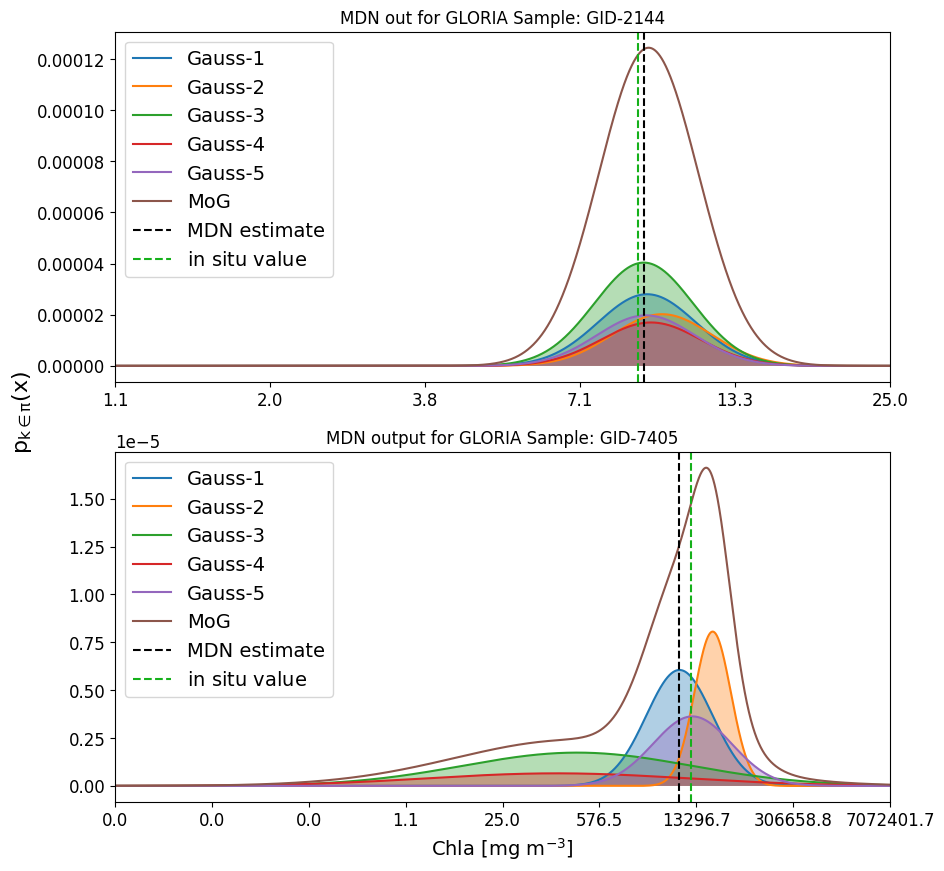

In [27]:
'Create a new figure to hold this information'
fig2, ax = plt.subplots(2, 1, figsize= (10, 10))
lims_plot  = [[-0.5, -0.0], [-2, 2]]
ticks_range = [0.1, 0.5]
title_list = ["MDN out for GLORIA Sample: " + gid_data[idx_1][0].replace('_', '-'), "MDN output for GLORIA Sample: " + gid_data[idx_2][0].replace('_', '-')]
ins_val = [y_data[idx_1], y_data[idx_2]]

scalery = mdn_preds_full['scalery'][0]
for ctr in range(2):
    'Get the different MoG components'
    weights = np.squeeze(mdn_preds_full['coefs'][0][0][ctr, :])
    mu = np.squeeze(mdn_preds_full['coefs'][0][1][ctr, :])
    var = np.squeeze(mdn_preds_full['coefs'][0][2][ctr, :])     # we are squeezing this down as in this case we a univariate model
    'Create a variable to hold the distribution'
    y_prob = None
    for ii in range(5):
        x_values = np.arange(-2, 2, 1.e-5)
        y_pdf = scipy.stats.norm(mu[ii], np.sqrt(var[ii]))
        y_values = y_pdf.pdf(x_values)
        y_values = y_values / y_values.sum()

        if y_prob is None:
            y_prob = weights[ii] * y_values
        else:
            y_prob += (weights[ii] * y_values)

        loc = ticker.LinearLocator(numticks=int(round((lims_plot[ctr][1] - lims_plot[ctr][0])/ticks_range[ctr])+1))
        fmt = ticker.FuncFormatter(lambda i, _: r"%1.1f" % (scalery.inverse_transform(i*np.ones((1,1)))))

        ax[ctr].fill_between(np.squeeze(x_values), 0, weights[ii]*y_values, alpha=0.35)
        ax[ctr].plot(np.squeeze(x_values), weights[ii]*y_values, linewidth=1.5, label=f"Gauss-{ii+1}")
        

    y_prob = y_prob/y_prob.sum()
    ax[ctr].plot(np.squeeze(x_values), y_prob, linewidth=1.5, label="MoG")
    ax[ctr].axvline(x=mu[np.argmax(weights)], color='k', linestyle='--', label="MDN estimate")
    ax[ctr].axvline(x=scalery.transform(ins_val[ctr]), color='xkcd:green', linestyle='--', label=r"$in~situ$ value")
    ax[ctr].set_xlim(lims_plot[ctr])

    ax[ctr].set_title(title_list[ctr])
    ax[ctr].xaxis.set_major_locator(loc)
    ax[ctr].xaxis.set_major_formatter(fmt)
    if ctr == 1:
        ax[ctr].set_xlabel(r'Chla [$mg~m^{-3}$]')
    ax[ctr].legend()


fig2.supylabel(r'p$_{k \in \pi}$(x)');            
                             

The plots in blue, orange, green, red, and purple show the individual Gaussian components (weighted as per the MoG weights). The plot in brown shows the combination of the five pdfs of the actual MoG for the specific sample. The dotted line in green shows the actual value of the <i>in situ</i> measurement of Chl<i>a</i> corresponding to that sample. Further, the line in black indicates the value corresponding to the mean of the Gaussian component with the largest weight in the predicted MoG for the specific sample. We highlight this particular value as this is the point estimate produced for a specific MDN when the <a style="font-family:'Courier New'">get_mdn_preds</a> is used in the <a style="font-family:'Courier New'">point</a> mode. For most applications we will require a point-estimate of each WQI/IOP for further analysis, comparision or decision making. Unlike in classical ML algorithms which directly predict point values for MDN we need to decide a scheme to extract the point-value from the predicted distribution. One such option is to identify the maximum likelihood solution. Given a MoG, the maximum likelihood solution will be the point which has the highest probability in the predicted distribution. For a simple distribution like the Gaussian distribution this problem is easy to solve, and the maximum likelihood point is just the mean of the distribution. MoG on the other hand can form complex multi modal distribution, and to completely solve this task (of identifying the largest likelihood value or mode of the distribution) would require the use  some kind of mode-finding algorithm. As one may expect mode-finding for a complex distribution can be a slow process. To enable speedy application of the MDNs we simply use the mean of the component with the largest weights as point estimate from the MoG. For some examples like the first-one we can see that the mean of the dominant distribution is indeed the highest mode of the composite distribution. That said this is not always true, the second example shows a scenario wherein the distribution combines in a different way. Based on some internal studies we have observed that using a more accurate mode finding algorithm is significantly slower and does not generate any noticeable improvement in prediction performance. This is aptly illustrated by the fact that the mode of the combined MoG of the second example is farther from the true <i> in situ</i> value than than the mean of the largest component considered by us at this stage. This section is intended to help understand some of the choices we have made in simplifying the multimodal MoG distribution into a single point estimate. That said, for your applications you can always extract the full MoG and apply an alternate mode finding strategy if you so choose.

[N.B: While studying/analyzing the plots above it is vital to note the different scales of the x-axis for the two plots under consideration. The top plot shows a distribution concentrated over a very small range of physical Chl<i>a</i> values, while the bottom plot is spread over a much larger Chl<i>a</i> range. Also of note: the x-axis changes exponentially rather than linearly. This property is due the fact that we use a log-scaler followed by MinMax scaler on the Chl<i>a</a> data prior to training.]

<b> <font size="+1" color="red">Section 3: Estimating Prediction Uncertainty for the MDN predicted MoGs</font></b>

As we have seen in the previous sections the MDN output clearly defines a MoG distribution over the possible values of the output variable. A similar thing is also shown in Fig. 1, where the only difference from above is that the each component is colored according to its component weight rather than scaled according to the component weight. Further, since the output is a distribution it is worth investiagting what additional information can be extracted from this distribution other than the point estimate which we will need for downstream processing. One valuable information point is the <b><i>prediction uncertainty</i></b>. The MDN like all other machine learning models is limited by two factors:
<ul>
    <li>The ability of the machine learning architecture to model the true data distribution. </li>
    <li>Similarity of the distribution of the test samples to the training data distributions. </li>
</ul>

Since we plan to apply these models (trained using <i>in situ</i> Rrs and IOP/WQI pairs) to satellite data we dont have a guarantee that the test samples will be similar to training samples. Additionally, our test data is affected significantly more by noise and distortion processes compared to the samples used in training. As such a measure/metric which encapsulates the models' confidence/uncertainty over a specific prediction would be valuable for down-stream decision making of end-users. The MDN predicted MoG distribution does indeed incorporate this information. Previous work by <a url="https://arxiv.org/abs/1709.02249" style="color:blue">[Choi et al. 2017]</a> shows the variance of the MoG distribution predicted by the MDN encodes the confidence of the MDN in a specific prediction.

<center>
<div style="border: 2px solid black; padding: 10px; width: fit-content; display: inline-block;">
    <img src="images/mdn_input_output_uncertainty.jpg" alt="MDN I/O and uncertainty" width="800" height="600" style="display: block; margin-bottom: 5px;" />
    <div style="text-align: center; font-family: Arial, sans-serif; font-size: 16px; color: #777;">
        Fig. 1: Visualizing the Input-Output pair of an MDN. Also describes method to estimate prediction uncertainty.
    </div>
</div>
</center>

Further, the MoG variance is itself composed of two components:
<ul> 
    <li><b> Expectation of variance:</b> is the uncertainty present in the prediction due to the noise in the data. This component is represented as the weighted combination of the individual component variances. This component is also thought to represent the <i>aleatoric or random uncertainty</i>.</li> </br>
    <li><b> Variance of Expectations:</b> is the uncertainty present in the dispersion or differences between the various component means in the MoG. This component is highly dependant on the data provided for model training and will be significantly affected if the training data distribution is modified. This component is thought to represent the <i>epistemic or data-dependant uncertainty</i>.</li>
</ul>

The information on the uncertainty which can be directly extracted from the MDN predictions are highly valuable and show very high correlation with unexpected data conditions like (i) Noise in the Data, (ii) Out-of-distribution data, (iii) Extreme atmospheric under or over-correction. Further, [Saranathan et al. 2023], show that there is some correlation between error/residuals and uncertainty, as such high uncertainty predictions are also expected to have higher estimation errors. Our toolbox provides the option to mask out predictions wherein uncertainty in the prediction >100% of the predicted value.



The MDN toolbox also contains a tool to estimate the uncertainty in the form of the function <a style="font::family:'Courier-New'">get_mdn_uncert_ensemble</a>. This function uses the coefficients of the entire ensemble of 10 models and calculates the uncertainty associated with each prediction. Finally it extracts from these only the uncertainty associated with median, as that is the prediction being used in this case.

In [10]:
'Get the uncertainties associated with the MDN predictions for each sample'
mdn_uncertainties = get_mdn_uncert_ensemble(mdn_preds_full['coefs'], np.asarray(mdn_preds_full['estimates']), mdn_preds_full['scalery'], scaler_mode="non_invert")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 6022.84it/s]


In [11]:
mdn_preds_full['coefs']

[[array([[0.22227134, 0.16217104, 0.3220212 , 0.1367368 , 0.1567996 ],
         [0.26027864, 0.18970889, 0.2559062 , 0.10949593, 0.18461032]],
        dtype=float32),
  array([[[-0.15677182],
          [-0.14706022],
          [-0.15889128],
          [-0.15422933],
          [-0.15749155]],
  
         [[ 0.9134335 ],
          [ 1.0847213 ],
          [ 0.38534087],
          [ 0.28099582],
          [ 0.98009497]]], dtype=float32),
  array([[[[0.00100011]],
  
          [[0.00102319]],
  
          [[0.00101086]],
  
          [[0.00103096]],
  
          [[0.00100108]]],
  
  
         [[[0.02941575]],
  
          [[0.00882063]],
  
          [[0.3467975 ]],
  
          [[0.44782704]],
  
          [[0.04116609]]]], dtype=float32)],
 [array([[0.13623826, 0.2731381 , 0.20438741, 0.1682097 , 0.21802658],
         [0.07742047, 0.3682005 , 0.239409  , 0.1532102 , 0.1617598 ]],
        dtype=float32),
  array([[[-0.10779658],
          [-0.10846015],
          [-0.11073504],
         

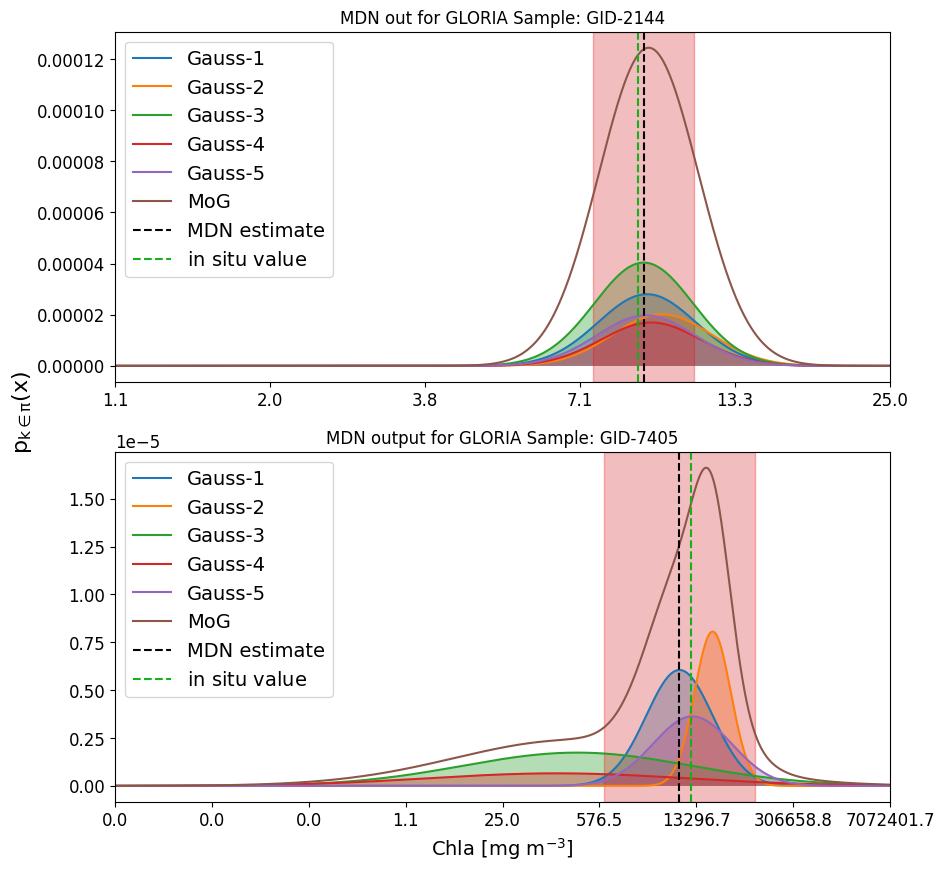

In [28]:
'Create a new figure to hold this information'
fig3, ax = plt.subplots(2, 1, figsize= (10, 10))
lims_plot  = [[-0.5, -0.0], [-2, 2]]
ticks_range = [0.1,0.5]
title_list = ["MDN out for GLORIA Sample: " + gid_data[idx_1][0].replace('_', '-'), "MDN output for GLORIA Sample: " + gid_data[idx_2][0].replace('_', '-')]
ins_val = [y_data[idx_1], y_data[idx_2]]

scalery = mdn_preds_full['scalery'][0]
for ctr in range(2):
    'Get the different MoG components'
    weights = np.squeeze(mdn_preds_full['coefs'][0][0][ctr, :])
    mu = np.squeeze(mdn_preds_full['coefs'][0][1][ctr, :])
    var = np.squeeze(mdn_preds_full['coefs'][0][2][ctr, :])     # we are squeezing this down as in this case we a univariate model
    'Create a variable to hold the distribution'
    y_prob = None
    for ii in range(5):
        x_values = np.arange(-2, 2, 1.e-5)
        y_pdf = scipy.stats.norm(mu[ii], np.sqrt(var[ii]))
        y_values = y_pdf.pdf(x_values)
        y_values = y_values / y_values.sum()

        if y_prob is None:
            y_prob = weights[ii] * y_values
        else:
            y_prob += (weights[ii] * y_values)

        loc = ticker.LinearLocator(numticks=int(round((lims_plot[ctr][1] - lims_plot[ctr][0])/ticks_range[ctr])+1))
        fmt = ticker.FuncFormatter(lambda i, _: r"%1.1f" % (scalery.inverse_transform(i*np.ones((1,1)))))

        ax[ctr].fill_between(np.squeeze(x_values), 0, weights[ii]*y_values, alpha=0.35)
        ax[ctr].plot(np.squeeze(x_values), weights[ii]*y_values, linewidth=1.5, label=f"Gauss-{ii+1}")

    y_prob = y_prob/y_prob.sum()
    ax[ctr].plot(np.squeeze(x_values), y_prob, linewidth=1.5, label="MoG")
    ax[ctr].axvline(x=mu[np.argmax(weights)], color='k', linestyle='--', label="MDN estimate")
    ax[ctr].axvline(x=scalery.transform(ins_val[ctr]), color='xkcd:green', linestyle='--', label=r"$in~situ$ value")
    y_min, y_max = ax[ctr].get_ylim()
    x_start, x_end = (mu[np.argmax(weights)] - (1.*mdn_uncertainties[ctr])), (mu[np.argmax(weights)] + (1.*mdn_uncertainties[ctr]))
    rectangle = patches.Rectangle((x_start, y_min), x_end - x_start, y_max - y_min, linewidth=1, edgecolor='r', facecolor='tab:red', alpha=0.3)
    ax[ctr].add_patch(rectangle)
    ax[ctr].legend()
    ax[ctr].set_xlim(lims_plot[ctr])
    ax[ctr].set_title(title_list[ctr])
    ax[ctr].xaxis.set_major_locator(loc)
    ax[ctr].xaxis.set_major_formatter(fmt)
    if ctr == 1:
        ax[ctr].set_xlabel(r'Chla [$mg~m^{-3}$]')


fig3.supylabel(r'p$_{k \in \pi}$(x)');            
                             

The above plots indicate the region of uncertainty as estimated using the distribution standard deviation on either side of the approximate maximum likelihood estimate (i.e. an interval of size 2&#963;). It is heartening to note that for both the examples the true value falls inside this region, clearly indicating that the model estimated uncertainty is an upper bound on prediction error. This is not simply a function of the examples chosen, but rather experiments like the ones shown in <a url="https://www.frontiersin.org/journals/remote-sensing/articles/10.3389/frsen.2024.1383147/full" style="color:blue"> [Saranathan et al. 2024]</a>, even when using a smaller uncertainty bound of (0.5&#962; on either side of the point estimate or an interval of size of) &#963; the estimated uncertainty metric proved to be an upper bound on the uncertainty metric for 75-80% test samples (i.e. samples not used in training). 

One important additional point to consider is that while the uncertainty region appears symmetric in the plots above the x-axis changes exponentially, thus the right side of the recatangle covers a larger phsyical range of values than the left side. This distortion occurs because of the use of a non-linear scaler on the output variables. In practise since we cannot invert the values of &#963; using a scaler, so we need to use an approximate process. Given y_hat&#770; is the scaled MDN prediction and &#963; the MoG standard deviation, we simply inverse scale the points y_hat&#770;-&#963; and y_hat&#770;+&#963;, and estimate the approximate scaled uncertainty as the difference between the two points. We simply express this value as the associated prediction uncertainty, but it is worth noting that this is a approximation.


<b style="color:blue"> References:</b> 

<p> 1. <a href="https://doi.org/10.3389/frsen.2024.1383147"> Assessment of advanced neural networks for the dual estimation of water quality indicators and their uncertainties</a>. A. M. Saranathan et al. (2024). Frontiers in Remote Sensing. 10.3389/frsen.2024.1383147.     </p>

<p>2.    
<a href="https://doi.org/10.1109/TGRS.2023.3234465"> Per-Pixel Uncertainty Quantification and Reporting for Satellite-Derived Chlorophyll-a Estimates via Mixture Density Networks</a>. A. M. Saranathan et al. (2023). IEEE Transactions on Geosciences and Remote Sensing. 10.1109/TGRS.2023.3234465.     </p>

<p>3. <a href="https://doi.org/10.1109/ICRA.2018.8462978"> Uncertainty-aware learning from demonstration using mixture density networks with sampling-free variance modeling.</a>.  Choi (2017). IEEE International Conference on Robotics and Automation. 10.1109/ICRA.2018.8462978.</p>